### Trabalho de validação de algoritmos de clusterização

O trabalho consiste em uma clusterização de dados de partidas do jogo Dota 2 (um dos jogos mais jogados no mundo) realizadas por competidores em ligas profissionais no ano de 2022. É um jogo que eu gosto, mas particularmente tenho dificuldades e, para entender melhor as features que levam à vitória e quais personagens estão sendo mais utilizados nos campeonatos e o porquê, o presente trabalho foi realizado.

A base de dados foi coletada em um site que disponibiliza dados estatísticos das partidas profissionais e também de todos os jogadores, mas, para acessar os meus dados, precisaria de pagar um certo valor em uma key para usar uma API, então foram obtidos dados de 20.000 jogos realizados por profissionais no ano de 2022. As informações sobre a base de dados são:

1. hero_id: o jogo possui mais de 120 personagens ditos heróis, cada um com habilidades específicas e muitas vezes desbalanceados;
2. kills: número de mortes que o jogador provoca;               
3. deaths: número de mortes sofridas;              
4. assists: número de assistências (participações em mortes);               
5. gold: quantidade de ouro obtida;                 
6. last_hits: quantidade de finalizações a unidades que não são jogadores. A cada finalização ganha-se ouro;             
7. denies: quantidade de finalizações das suas próprias unidades para que o jogador do time adversário não ganhe ouro;                
8. gold_per_min: quantidade de ouro por minuto, geralmente reflete uma boa partida em termos de recursos;         
9. xp_per_min: quantidade de experiência por minuto, geralmente reflete uma boa partida em termos de nível de personagem;            
10. gold_spent: ouro gasto;            
11. hero_damage: dano total em uma partida provocado a outros jogadores;           
12. tower_damage: dano total em uma partida provocado a estruturas;        
13. hero_healing: cura total proporcionada por heróis que tem esse tipo de habilidade;         
14. level: nível do personagem;                
15. firstblood_claimed: se o personagem provocou a primeira morte do jogo ou não. Ela é mais valorizada do que as convencionais;  
16. roshans_killed: roshan é um personagem que quando derrotado dá uma vantagem grande para o time que o derrotou;      


A imagem a baixo ilustra como os dados foram obtidos no www.opendota.com:
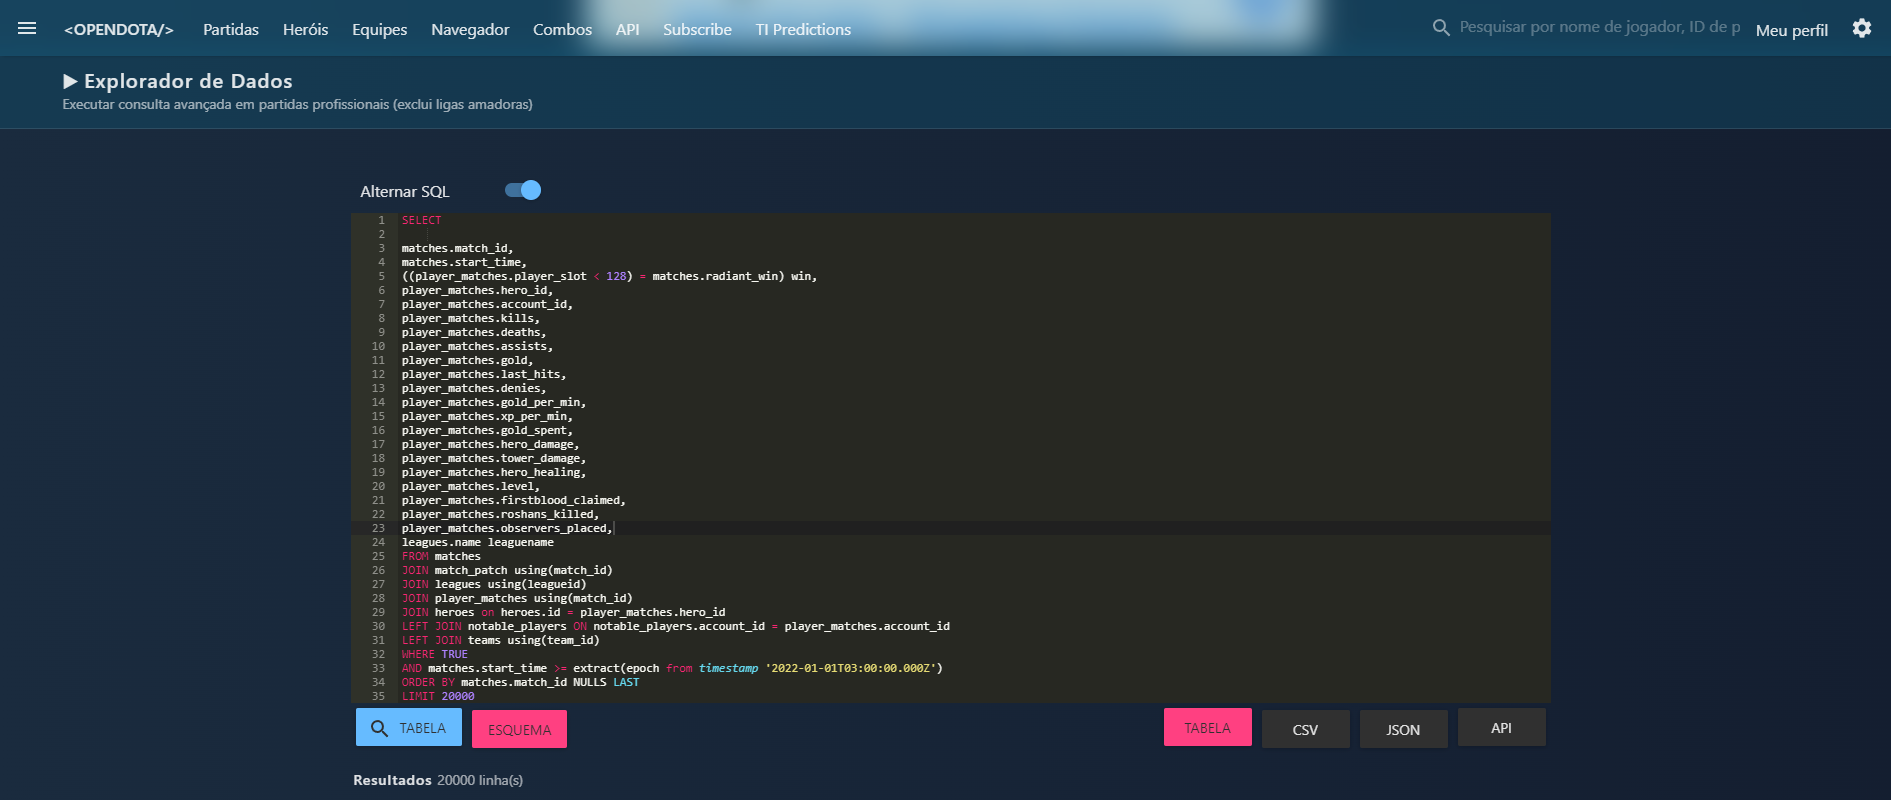

A imagem a baixo ilustra como os dados são comumente representados nos sites de estatísticas de partidas:
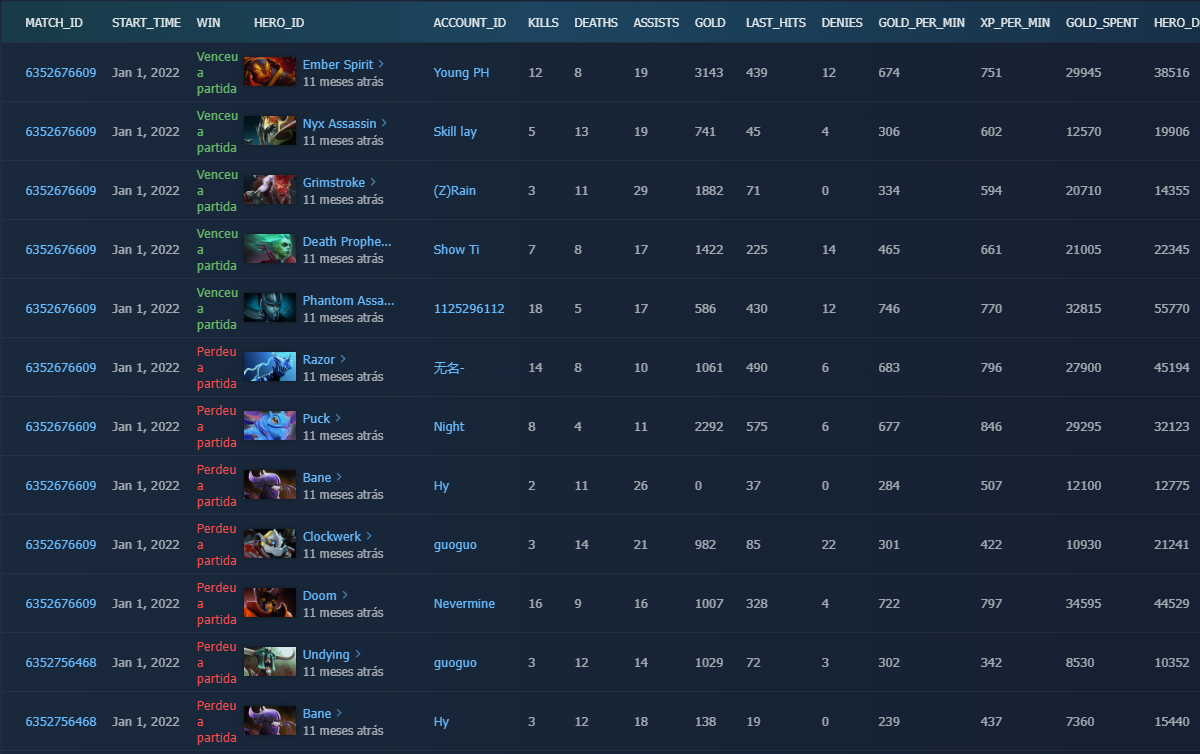

O trabalho se desenvolveu por meio da seguinte sequência:

1. Importação das bibliotecas que serão usadas
2. Preparação dos dados e análise das distribuições
3. A clusterização utilizando o algoritmo DBSCAN
4. Utilização dos métodos do cotovelo e silhueta e discussão sobre este segundo método
5. A clusterização utilizando o algoritmo Kmeans
6. Comparação entre os resultados das duas clusterizações
7. Resposta a algumas perguntas a respeito de séries temporais


## 1. Importação das bibliotecas que serão usadas

In [335]:
#Uso geral
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Pré-processamento
import pylab
from sklearn.impute import KNNImputer

#Normalização
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.compose import ColumnTransformer

#Análise da variância
from sklearn.decomposition import PCA

#Visualuzação dos dados em duas dimensões
from sklearn.manifold import TSNE

#DBSCAN
from itertools import product
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

#KMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples


## 2. Preparação dos dados e análise das distribuições

Os dados foram carregados e a única coluna que não era numérica (win) foi convertida. Os valores NaN foram tratados e removidos. As distribuições foram plotadas e analisadas, para as distruibuições gaussianas a padronização utilizada foi o StandardScaler e para a maioria das distribuições Power Law foi utilizado o normalizador MinMaxScaler. O RobustScaler foi utilizado para remover valores abaixo de 0.1 percentil e acima de 0.9 percentil e assim eliminar parte dos outliers.

In [336]:
dota_data = pd.read_csv("../../dataset/dota2.csv")
dota_data.head()

match_id  start_time   win  hero_id  account_id  kills  deaths  assists  \
0  6352676609  1641014016  True      106   360648679     12       8       19   
1  6352676609  1641014016  True       88   318371533      5      13       19   
2  6352676609  1641014016  True      121   318286721      3      11       29   
3  6352676609  1641014016  True       43   104504914      7       8       17   
4  6352676609  1641014016  True       44  1125296112     18       5       17   

   gold  last_hits  ...  xp_per_min  gold_spent  hero_damage  tower_damage  \
0  3143        439  ...         751       29945        38516          1621   
1   741         45  ...         602       12570        19906            39   
2  1882         71  ...         594       20710        14355            83   
3  1422        225  ...         661       21005        22345          2181   
4   586        430  ...         770       32815        55770          4103   

   hero_healing  level  firstblood_claimed  roshans_killed  observers_placed  \
0           285     28                 0.0             0.0               1.0   
1             8     25                 0.0             1.0               4.0   
2          2455     25                 0.0             0.0              18.0   
3             0     26                 0.0             1.0               0.0   
4           110     29                 0.0             0.0               0.0   

          leaguename  
0  Asia New Star Cup  
1  Asia New Star Cup  
2  Asia New Star Cup  
3  Asia New Star Cup  
4  Asia New Star Cup  

[5 rows x 22 columns]

In [337]:
dota_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   match_id            20000 non-null  int64  
 1   start_time          20000 non-null  int64  
 2   win                 20000 non-null  bool   
 3   hero_id             20000 non-null  int64  
 4   account_id          20000 non-null  int64  
 5   kills               20000 non-null  int64  
 6   deaths              20000 non-null  int64  
 7   assists             20000 non-null  int64  
 8   gold                20000 non-null  int64  
 9   last_hits           20000 non-null  int64  
 10  denies              20000 non-null  int64  
 11  gold_per_min        20000 non-null  int64  
 12  xp_per_min          20000 non-null  int64  
 13  gold_spent          20000 non-null  int64  
 14  hero_damage         20000 non-null  int64  
 15  tower_damage        20000 non-null  int64  
 16  hero

In [338]:
dota_data.describe()

match_id    start_time       hero_id    account_id         kills  \
count  2.000000e+04  2.000000e+04  20000.000000  2.000000e+04  20000.000000   
mean   6.388825e+09  1.642742e+09     64.486150  4.858906e+08      5.921150   
std    2.001241e+07  9.661890e+05     38.822333  4.442364e+08      4.693616   
min    6.352677e+09  1.641014e+09      1.000000  5.150808e+06      0.000000   
25%    6.371437e+09  1.641903e+09     34.000000  1.421393e+08      2.000000   
50%    6.387527e+09  1.642687e+09     63.000000  2.375786e+08      5.000000   
75%    6.406495e+09  1.643570e+09     95.000000  1.002244e+09      8.000000   
max    6.423834e+09  1.644451e+09    135.000000  1.281315e+09     44.000000   

             deaths       assists         gold     last_hits        denies  \
count  20000.000000  20000.000000  20000.00000  20000.000000  20000.000000   
mean       6.035200     12.030850   1748.82435    177.739950      6.688000   
std        3.703721      6.968517   1677.83965    144.320768      6.070486   
min        0.000000      0.000000      0.00000      0.000000      0.000000   
25%        3.000000      7.000000    655.00000     49.000000      2.000000   
50%        6.000000     11.000000   1271.00000    154.000000      5.000000   
75%        8.000000     16.000000   2281.00000    269.000000     10.000000   
max       27.000000     45.000000  40857.00000   1065.000000     68.000000   

       gold_per_min    xp_per_min    gold_spent    hero_damage  tower_damage  \
count  20000.000000  20000.000000  20000.000000   20000.000000   20000.00000   
mean     441.546050    559.725550  13771.300750   18990.270150    2445.61860   
std      168.384648    190.051862   7032.725957   12220.153247    4253.06233   
min      120.000000     50.000000      0.000000       0.000000       0.00000   
25%      303.000000    424.000000   8585.000000   10603.000000      94.00000   
50%      422.000000    556.000000  12420.000000   16029.500000     631.00000   
75%      566.000000    702.000000  17925.000000   24513.500000    2574.25000   
max     1032.000000   1164.000000  62765.000000  213881.000000   34702.00000   

       hero_healing         level  firstblood_claimed  roshans_killed  \
count  20000.000000  20000.000000        19930.000000    19930.000000   
mean     728.921350     19.789950            0.095886        0.166734   
std     2327.023767      5.045156            0.294442        0.442428   
min        0.000000      4.000000            0.000000        0.000000   
25%        0.000000     16.000000            0.000000        0.000000   
50%        0.000000     20.000000            0.000000        0.000000   
75%      400.000000     24.000000            0.000000        0.000000   
max    59249.000000     30.000000            1.000000        4.000000   

       observers_placed  
count      19930.000000  
mean           3.153487  
std            4.300212  
min            0.000000  
25%            0.000000  
50%            2.000000  
75%            4.000000  
max           32.000000

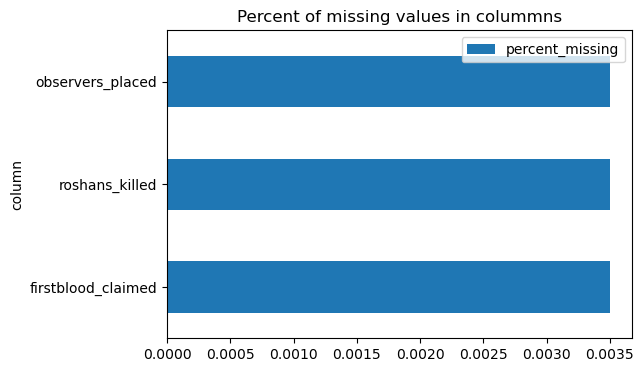

In [339]:
#Verificação se existem valores faltando no dataset
def plot_missing_values(df):
    """ For each column with missing values plot proportion that is missing."""
    data = [(col, df[col].isnull().sum() / len(df)) 
            for col in df.columns if df[col].isnull().sum() > 0]
    col_names = ['column', 'percent_missing']
    missing_df = pd.DataFrame(data, columns=col_names).sort_values('percent_missing')
    pylab.rcParams['figure.figsize'] = (6, 4)
    missing_df.plot(kind='barh', x='column', y='percent_missing')
    plt.title('Percent of missing values in colummns')


plot_missing_values(dota_data)

In [340]:
#Removendo as colunas que não tem relevância
dota_data.drop(["firstblood_claimed", "match_id", "start_time", "account_id", "hero_healing", "leaguename"], axis=1, inplace=True)

#Renomeando a coluna de level
dota_data.rename(columns={"level": "hero_level"}, inplace=True)

#Imputando valores aos valores NaN do dataset
imputer = KNNImputer(n_neighbors=5, weights="uniform")
suport_data = dota_data['win']
dota_data.drop(['win'], axis=1, inplace=True)
dota_data = pd.DataFrame(imputer.fit_transform(dota_data), columns=dota_data.columns)
dota_data.insert(0, 'win', suport_data)

#Removendo dados NaN nativos
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "A base de dados precisa ser um pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)


#Convertendo os dados booleanos da coluna win para valores numéricos
def win_to_numeric(win_status):
  if win_status is True:
    return 1
  else:
    return 0

clean_dataset(dota_data)
dota_data["win"] = dota_data["win"].apply(win_to_numeric)
dota_data

/tmp/ipykernel_413/4172240383.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)


win  hero_id  kills  deaths  assists    gold  last_hits  denies  \
0        1    106.0   12.0     8.0     19.0  3143.0      439.0    12.0   
1        1     88.0    5.0    13.0     19.0   741.0       45.0     4.0   
2        1    121.0    3.0    11.0     29.0  1882.0       71.0     0.0   
3        1     43.0    7.0     8.0     17.0  1422.0      225.0    14.0   
4        1     44.0   18.0     5.0     17.0   586.0      430.0    12.0   
...    ...      ...    ...     ...      ...     ...        ...     ...   
19995    0     88.0    3.0     8.0     16.0  1024.0       24.0     3.0   
19996    0     60.0    7.0     6.0     10.0  1135.0      107.0    14.0   
19997    0    128.0    4.0     9.0     21.0   478.0       40.0     3.0   
19998    0     48.0    4.0     7.0      9.0   675.0      225.0     9.0   
19999    0     78.0   12.0     5.0     11.0   980.0      126.0     3.0   

       gold_per_min  xp_per_min  gold_spent  hero_damage  tower_damage  \
0             674.0       751.0     29945.0      38516.0        1621.0   
1             306.0       602.0     12570.0      19906.0          39.0   
2             334.0       594.0     20710.0      14355.0          83.0   
3             465.0       661.0     21005.0      22345.0        2181.0   
4             746.0       770.0     32815.0      55770.0        4103.0   
...             ...         ...         ...          ...           ...   
19995         267.0       421.0      6375.0      13924.0           0.0   
19996         382.0       503.0      9235.0      16034.0         603.0   
19997         296.0       365.0      7625.0      15896.0          39.0   
19998         458.0       528.0     12280.0      17482.0         910.0   
19999         455.0       556.0     11025.0      24457.0         673.0   

       hero_level  roshans_killed  observers_placed  
0            28.0             0.0               1.0  
1            25.0             1.0               4.0  
2            25.0             0.0              18.0  
3            26.0             1.0               0.0  
4            29.0             0.0               0.0  
...           ...             ...               ...  
19995        16.0             0.0               8.0  
19996        18.0             0.0               0.0  
19997        14.0             0.0               5.0  
19998        18.0             0.0               0.0  
19999        19.0             0.0               0.0  

[20000 rows x 16 columns]

In [341]:
#Plotagem das distribuições
#for col in dota_data.columns:
    #plt.figure(figsize=(20,9))
    #sns.histplot(dota_data[col], color="mediumspringgreen")
    #plt.show()

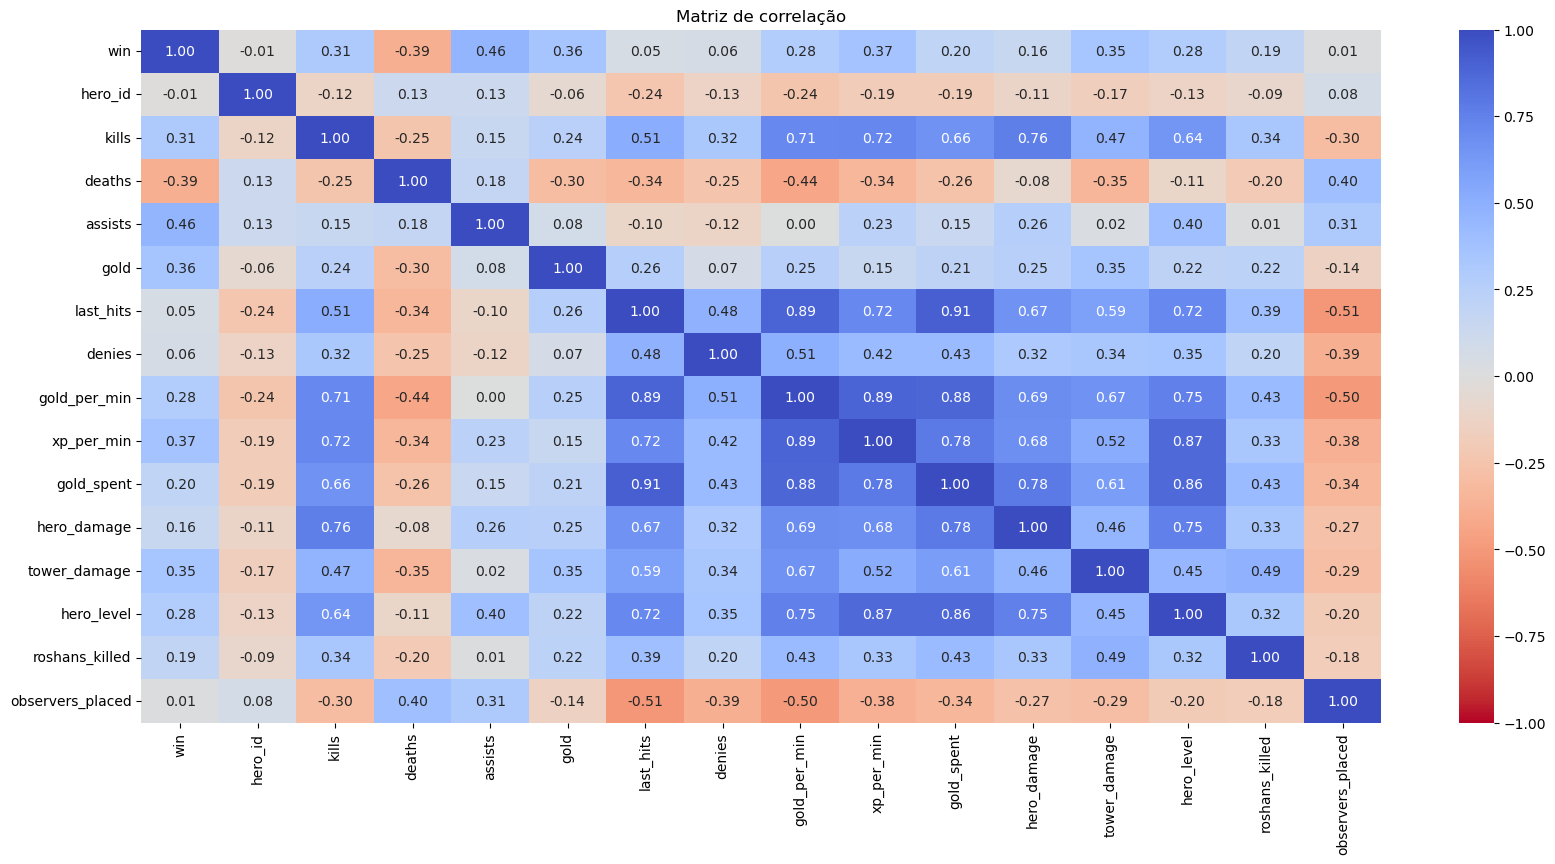

In [342]:
#Análise da correlação entre as variáveis
plt.figure(figsize=(20,9))
sns.heatmap(dota_data.corr(), cmap="coolwarm_r", vmin=-1, annot=True, fmt=".2f")
plt.title("Matriz de correlação")
plt.show()

Percebe-se que apesar de ser uma base de dados não comportada, várias correlações se aproximam de um, entretanto, como se espera de um jogo, existe uma contribuição das variáveis, mas não uma certeza de vitória na partida em decorrência delas. A proximidade de um se traduz em uma relação de linearidade entre as variáveis e, geralmente é a situação preferível. Um fato interessante é que a maior contribuição para a vitória na partida vem das assistências, e não das mortes provocadas pelo personagem (inclusive é um valor relativamente bem maior), o que demonstra que se trata realmente de um jogo de equipe e não de jogadas individuais.

In [343]:
#sns.pairplot(dota_data)
#plt.suptitle('Pairplot', y=1.05)

In [344]:
#Tratamento, padronização e normalização dos dados de acordo com as suas distribuições
categorical_columns = ['win', 'hero_id', 'roshans_killed']
power_law_columns = ['tower_damage', 'gold', 'denies', 'observers_placed']
gaussian_columns = list(set(dota_data.columns)-set(power_law_columns)-set(categorical_columns))
power_law_dota_data = dota_data[power_law_columns]
gaussian_dota_data = dota_data[gaussian_columns]

#Aplicando as transformações de acordo com o tipo de distribuição
gaussian_dota_data_scaled = pd.DataFrame(StandardScaler().fit_transform(gaussian_dota_data), columns=gaussian_columns)

pt = PowerTransformer(standardize=True)
power_law_dota_data_scaled = pd.DataFrame(pt.fit_transform(power_law_dota_data), columns=power_law_columns)

dota_data_scaled = pd.concat([dota_data[categorical_columns], power_law_dota_data_scaled, gaussian_dota_data_scaled], axis=1)
dota_data_scaled.head()

win  hero_id  roshans_killed  tower_damage      gold    denies  \
0    1    106.0             0.0      0.482159  1.033389  1.006787   
1    1     88.0             1.0     -0.860466 -0.534844 -0.198639   
2    1    121.0             0.0     -0.648851  0.400802 -1.811712   
3    1     43.0             1.0      0.626406  0.092598  1.205965   
4    1     44.0             0.0      0.956442 -0.733378  1.006787   

   observers_placed  xp_per_min  last_hits   assists  hero_level  \
0         -0.162587    1.006458   1.810319  1.000116    1.627354   
1          0.797385    0.222442  -0.919779  1.000116    1.032709   
2          1.757139    0.180347  -0.739621  2.435177    1.032709   
3         -1.114549    0.532891   0.327474  0.713104    1.230924   
4         -1.114549    1.106433   1.747956  0.713104    1.825569   

   gold_per_min  hero_damage    deaths  gold_spent     kills  
0      1.380528     1.597870  0.530507    2.299834  1.295164  
1     -0.804999     0.074938  1.880534   -0.170820 -0.196261  
2     -0.638709    -0.379323  1.340523    0.986655 -0.622382  
3      0.139291     0.274531  0.530507    1.028603  0.229860  
4      1.808131     3.009835 -0.279510    2.707937  2.573528

In [345]:
#sns.pairplot(dota_data_scaled)
#plt.suptitle('Pairplot', y=1.05)

Text(0, 0.5, 'Proporção cumulativa de variância')

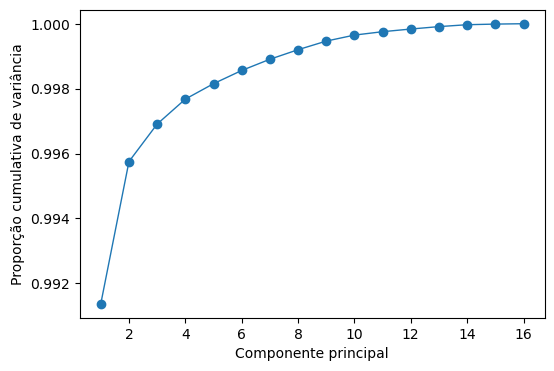

In [346]:
#Analisando o acúmulo da variância em função dos componentes
pca = PCA()
dota_pca = pca.fit(dota_data_scaled)
plt.plot(np.arange(1,17), np.cumsum(dota_pca.explained_variance_ratio_), 'o-', linewidth='1')
plt.xlabel('Componente principal')
plt.ylabel('Proporção cumulativa de variância')

Percebe-se que muitas variáveis tem contribuição na variância, o que reflete a importância de mantê-las para a posterior clusterização.

## 3. A clusterização utilizando o algoritmo DBSCAN

Da visualização dos dados em duas dimensões utilizando-se a ferramenta TSNE do sklearn conclui-se que uma clusterização utilizando-se o DBSCAN será mais eficiente do que a clusterização utilizando-se o KMeans. Nesta etapa foi feita uma exploração dos valores de épsilon (eps) e dos valores mínimos de vizinhança para a consideração de ser um dado core (min_samples).

/home/higoreller/miniconda3/envs/clustering-validation-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/higoreller/miniconda3/envs/clustering-validation-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


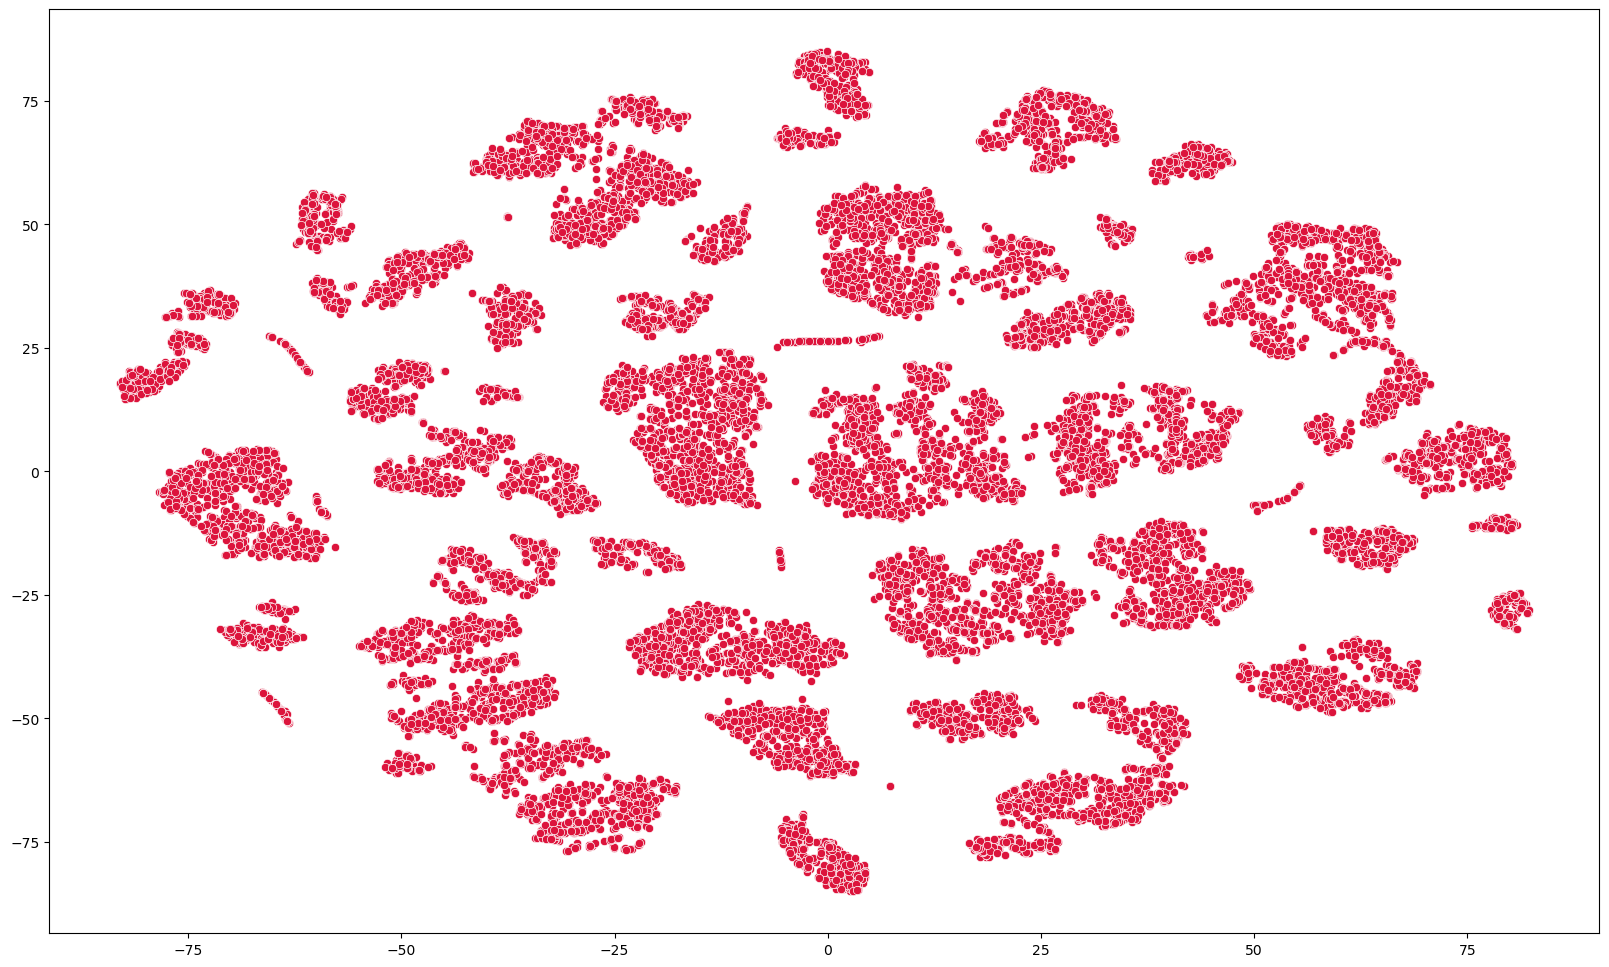

In [347]:
#Para visualização dos dados em duas dimensões
tsne = TSNE(random_state=42)
tsne_data = tsne.fit_transform(dota_data_scaled)

plt.figure(figsize=(20,12))
sns.scatterplot(x=tsne_data[:,0], y=tsne_data[:,1], color="crimson")
plt.show()

In [348]:
#Exploração dos valores de eps e min_samples
eps_values = np.arange(start=1.4, stop=2.4, step=0.1) #Valores de épsilon que serão investigados
min_samples = np.arange(3,10) #Valores de vizinhança para um ponto ser considerado como ponto core
DBSCAN_params = list(product(eps_values, min_samples))
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(dota_data_scaled)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(dota_data_scaled, DBS_clustering.labels_))
    


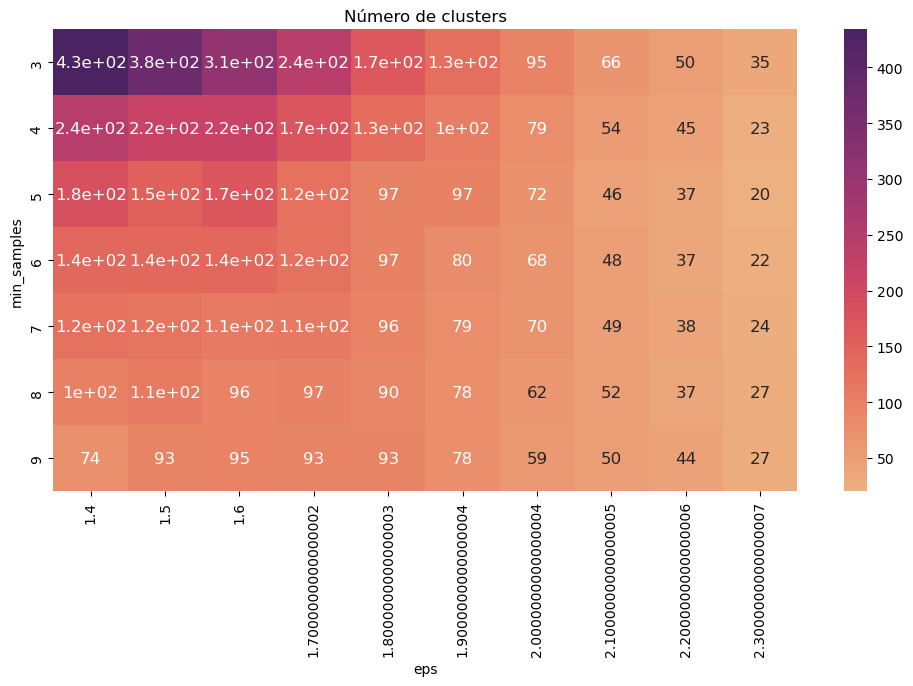

In [349]:
#Plot de um gráfico para se entender o número de clusters gerados a partir de eps e min_samples específicos
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['eps', 'min_samples'])   
tmp['no_of_clusters'] = no_of_clusters

eps_min_samples_table = pd.pivot_table(tmp, values='no_of_clusters', index='min_samples', columns='eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(eps_min_samples_table, annot=True, annot_kws={"size": 12}, cmap="flare", ax=ax)
ax.set_title('Número de clusters')
plt.show()

Da análise visual desta figura conseguimos ter uma noção de quais parâmetros iremos utilizar para a clusterização com o DBSCAN, já que este algoritmo não parte de um número de clusters predefinido.

In [350]:
#Execução do DBSCAN a partir dos parâmetros obtidos anteriormente
DBSCAN_clustering = DBSCAN(eps=2, min_samples=4).fit(dota_data_scaled)
DBSCAN_clustered = dota_data_scaled.copy()
DBSCAN_clustered.loc[:,'cluster'] = DBS_clustering.labels_
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]

#Atribuindo as labels geradas pela clusterização a uma coluna do dataset inicial
dota_data['dbscan_cluster'] = DBS_clustering.labels_

#Verificação do tamanho dos clusters para uma primeira análise da magnitude
DBSCAN_clust_sizes

DBSCAN_size
cluster             
-1              1478
 0              3696
 1              2934
 2              2972
 3               569
 4              1469
 5              1543
 6               350
 7              1154
 8              1391
 9              1743
 10              115
 11               67
 12               29
 13               60
 14               96
 15               27
 16               26
 17               19
 18               29
 19               69
 20               47
 21               14
 22               75
 23               16
 24                5
 25                7

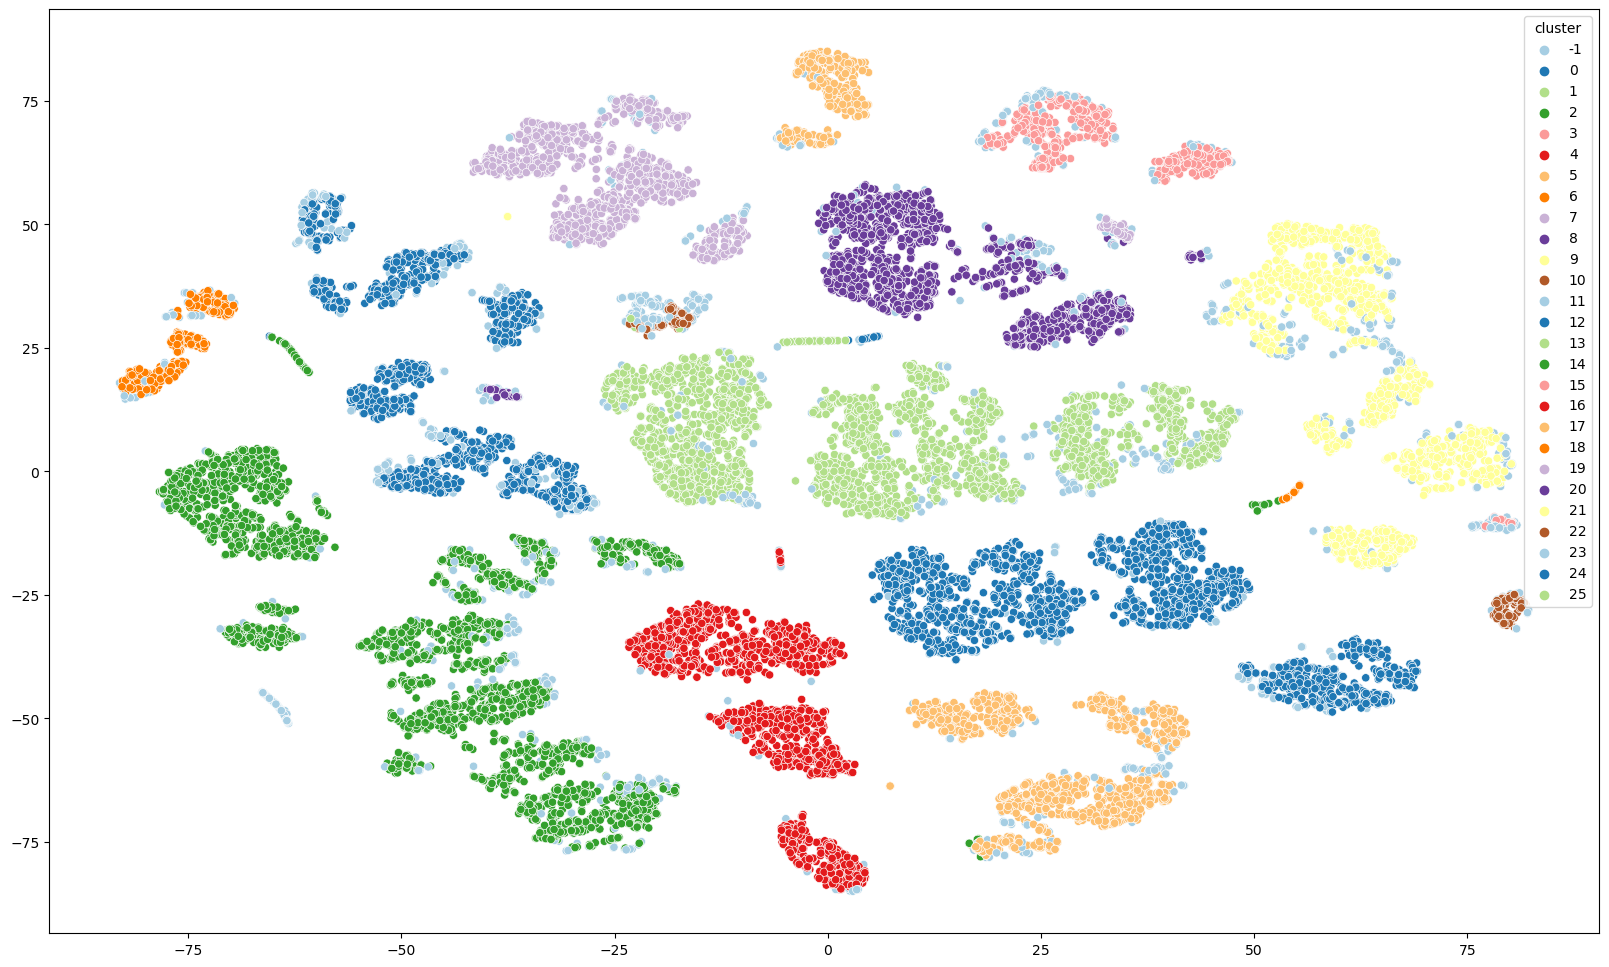

In [351]:
#Verificação da distribuição dos dados já clusterizados
DBSCAN_clustered['cluster']
len(set(DBSCAN_clustered['cluster']))

plt.figure(figsize=(20,12))
sns.scatterplot(x=tsne_data[:,0], y=tsne_data[:,1], hue=DBSCAN_clustered['cluster'], palette="Paired")
plt.show()

In [358]:
#Removendo os valores dos clusters 12, 15, 16, 17, 18, 21, 23, 24 e 25
for i in [12, 15, 16, 17, 18, 21, 23, 24, 25]:
    dota_data['dbscan_cluster'][dota_data['dbscan_cluster']==i] = -1

dota_data.groupby('dbscan_cluster').size().to_frame()


/tmp/ipykernel_413/2635221719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dota_data['dbscan_cluster'][dota_data['dbscan_cluster']==i] = -1


0
dbscan_cluster      
-1              1650
 0              3696
 1              2934
 2              2972
 3               569
 4              1469
 5              1543
 6               350
 7              1154
 8              1391
 9              1743
 10              115
 11               67
 13               60
 14               96
 19               69
 20               47
 22               75

## 4. Utilização dos métodos do cotovelo e silhueta e discussão sobre este segundo método

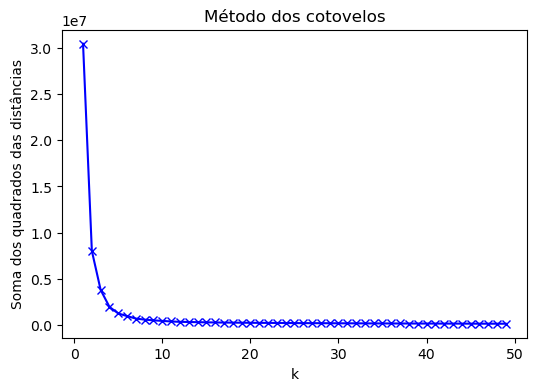

In [352]:
#Execução do método dos cotovelos apenas de forma auxiliar
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(dota_data_scaled)
    sum_of_squared_distances.append(km.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma dos quadrados das distâncias')
plt.title('Método dos cotovelos')
plt.show()

### Método da silhueta

Para verificar alguns aspectos de "qualidade" de uma clusterização existem métodos de validação interna e externa. Os métodos de validação interna pressupõe olhar o modelo de cluster e analisar os seus parâmetros, perceber como a função objetivo se comporta no final da clusterização. Alguns exemplos desses métodos são: silhueta e magnitude. É importante conhecer a medida de validação que se está utilizando, e também quando ela funciona para o problema e quando ela não funciona. É importante saber como a métrica e sua proposta funcionam e evitar fazer uso de métodos sem ter conhecimento.

•	Silhueta: medida da consistência do conjunto de dados. No caso perfeito, a silhueta se aproxima do valor um. Quando o valor de silhueta se aproxima de zero significa que a distância do elemento ao seu centroide é próxima da distância ao ponto mais próximo do cluster vizinho, ou seja, o ponto está em uma região de fronteira. Quando o valor é muito próximo de -1, traduz a situação de que um ponto foi associado a um cluster, mas deveria estar associado a outro. A medida da silhueta é realiza por amostra, e por isso pode indicar se um ponto em específico está em uma região de fronteira ou não. É uma medida normalizada, contribuindo em muito na interpretação dos dados. Analisa coesão e separação, que são avaliações clássicas. Quando a silhueta é ruim? A silhueta funciona bem em clusters convexos, quando se tem uma curvatura diferenciada da forma convexa este método não é uma boa escolha, pois na contabilização das distâncias entre os pontos e seus centroides e entre outros pontos o algoritmo fica prejudicado acusando regiões de fronteira. Não se usa silhueta para comparar diferentes modelos de clusters. Em caso de suspeita de não convexidade NÃO UTILIZE A SILHUETA.

Dito isto o passo a passo para a obtenção do índice de silhueta é:
1. 


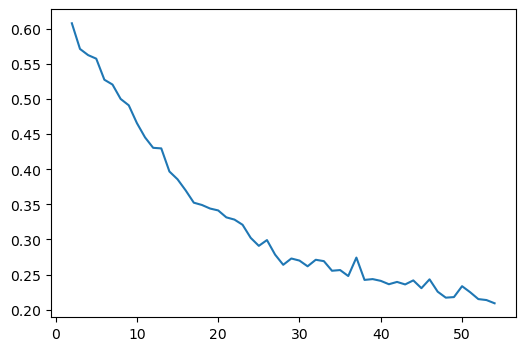

In [353]:
from sklearn.metrics import silhouette_score

sse_ = []
for k in range(2, 55):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(dota_data_scaled)
    sse_.append([k, silhouette_score(dota_data_scaled, kmeans.labels_)])
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.show()

Para n_clusters = 24 O score_silhouette médio é : 0.12033975590086621
Para n_clusters = 25 O score_silhouette médio é : 0.12116928127604654
Para n_clusters = 26 O score_silhouette médio é : 0.11665985923503262
Para n_clusters = 27 O score_silhouette médio é : 0.11734584308930414


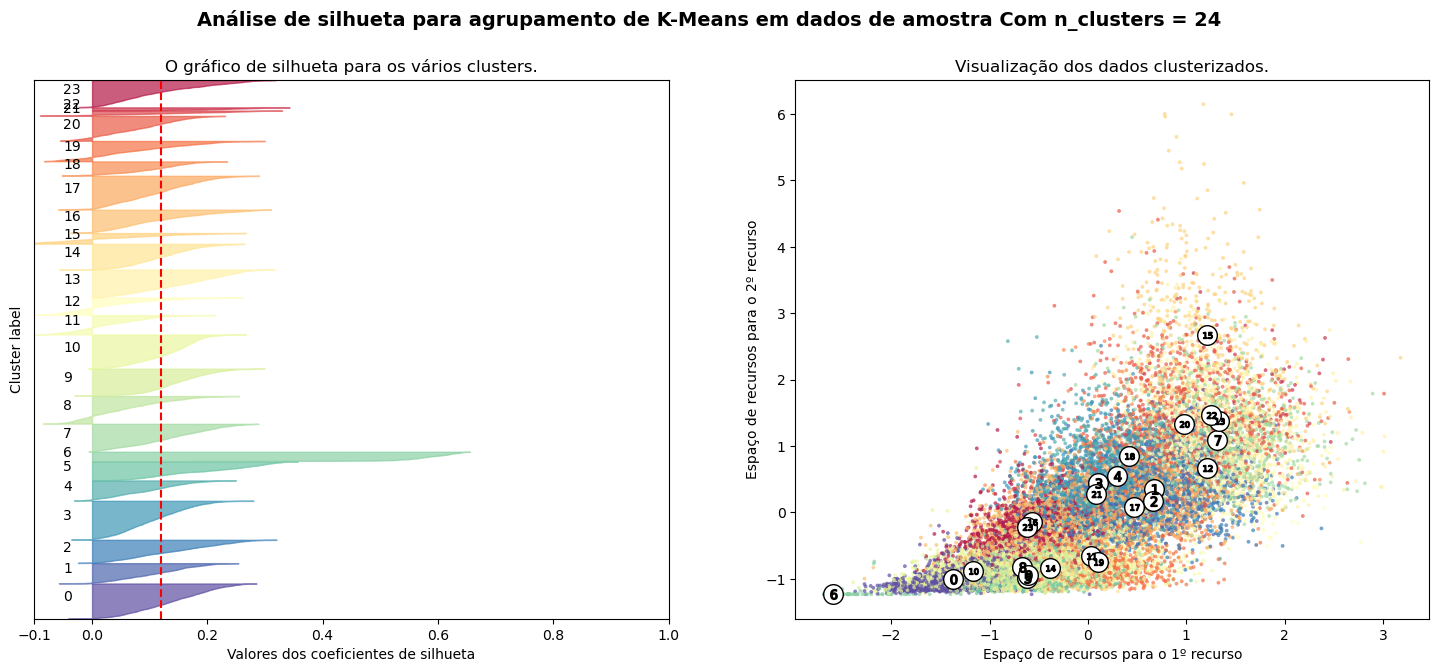

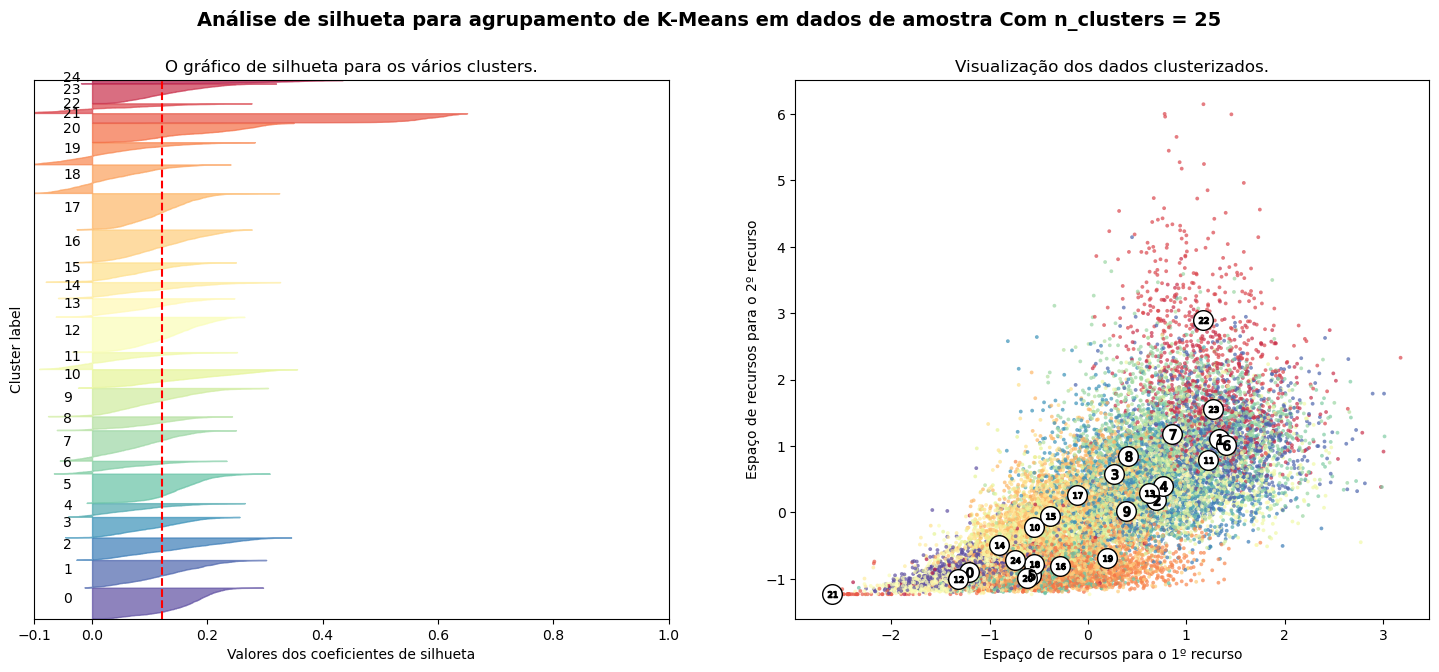

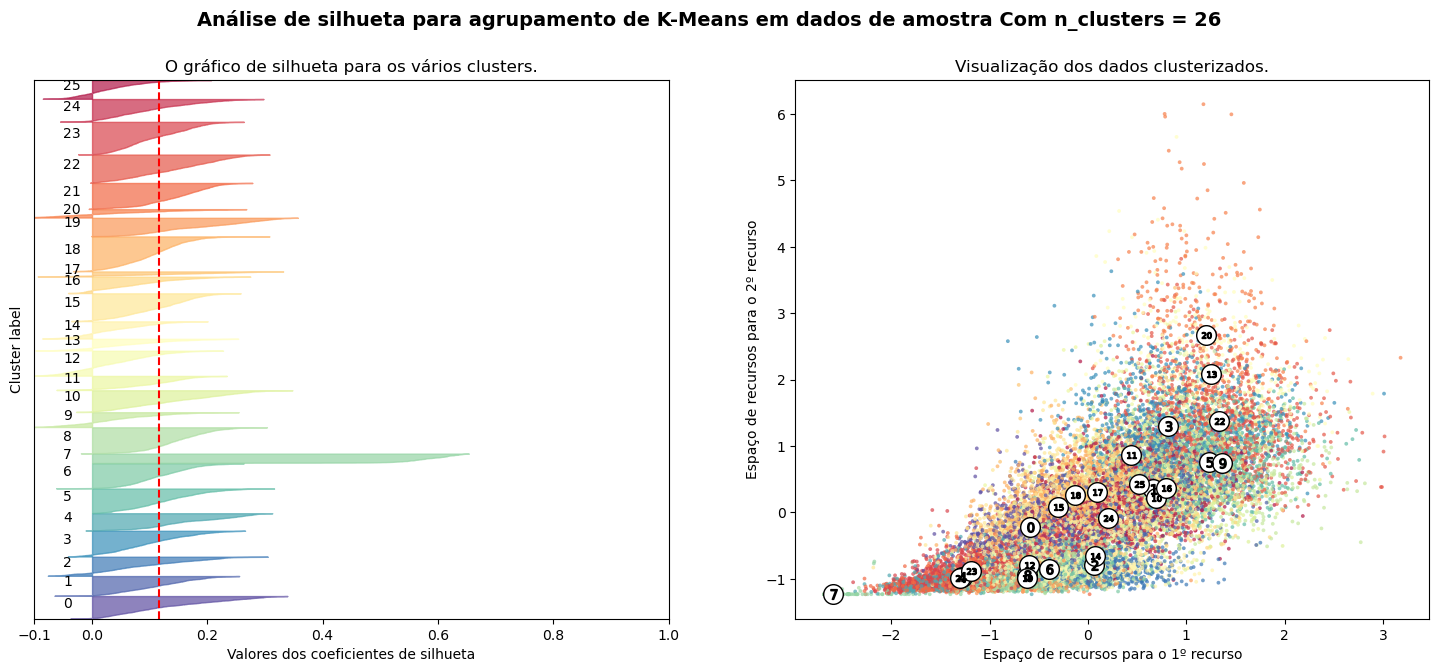

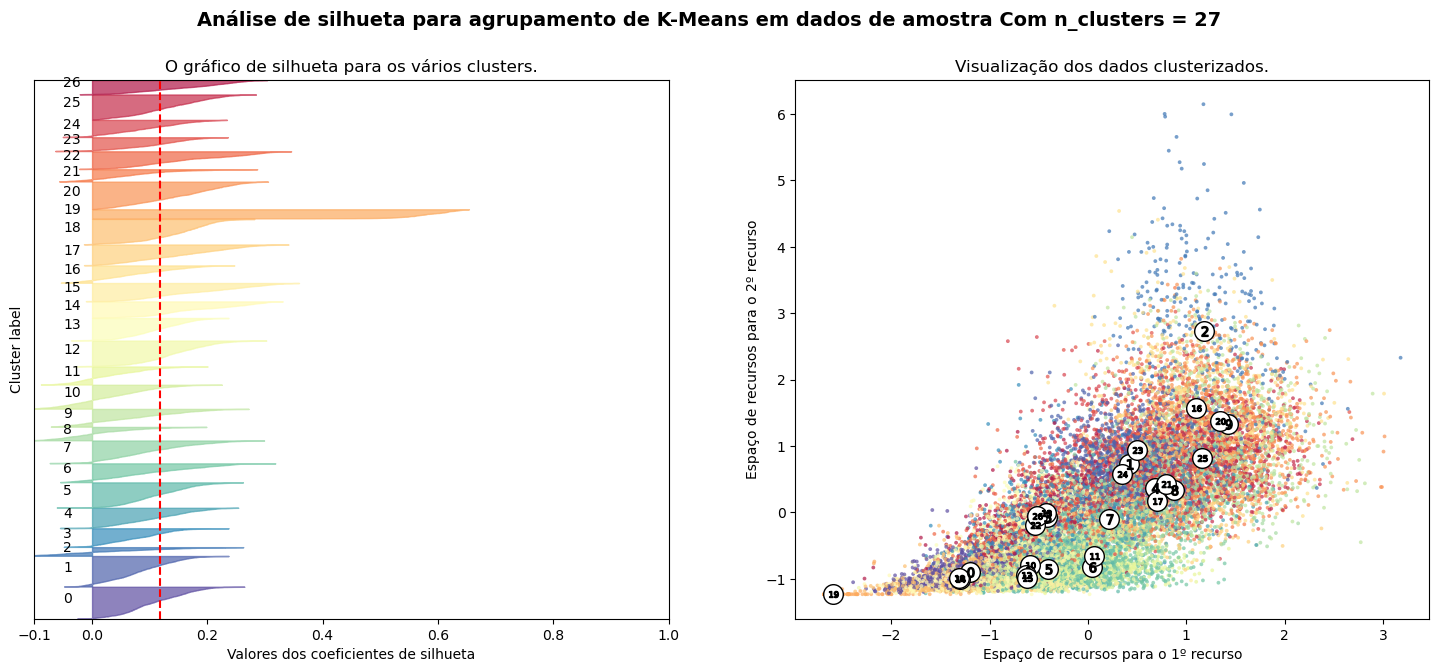

In [361]:
import matplotlib.cm as cm

#Obtendo os coeficientes de silhueta para verificar se os dados possuem estrutura razoável para serem
#clusterizados em 6 ou 7 clusters como demonstra a figura anterior
range_n_clusters = [24, 25, 26, 27]

for n_clusters in range_n_clusters:
    #Criando um subplot com uma linha e duas colunas
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    #Os coeficientes de silhueta irão variar entre [-0.1, 1]
    ax1.set_xlim([0, 1])
    #O (n_clusters+1)*10 é para inserir espaço em branco entre os agrupamentos individuais, para demarcá-los claramente.
    ax1.set_ylim([0, len(dota_data_scaled) + (n_clusters + 1) * 10])
    #Inicializando a clusterização com um número n_clusters e com a seed de 33 para assegurar a reprodutibilidade dos resultados
    clusterer = KMeans(n_clusters=n_clusters, random_state=33)
    cluster_labels = clusterer.fit_predict(dota_data_scaled)
    #O silhouette_score dá o valor médio para todas as amostras.
    #Isso dá uma perspectiva sobre a densidade e separação dos clusters formados.
    silhouette_avg = silhouette_score(dota_data_scaled, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette médio é :", silhouette_avg)
    #Calculando as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(dota_data_scaled, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregando as pontuações de silhueta para amostras pertencentes a i e classificá-las
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral_r")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        #Rotulando os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        #Calculando o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_title("O gráfico de silhueta para os vários clusters.")
    ax1.set_xlabel("Valores dos coeficientes de silhueta")
    ax1.set_ylabel("Cluster label")
    #Linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    #2º gráfico mostrando os clusters reais formados
    cmap = cm.get_cmap("Spectral_r")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dota_data_scaled.iloc[:, 0], dota_data_scaled.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    #Rotulando os clusters
    centers = clusterer.cluster_centers_
    #Desenhando círculos brancos nos centros dos clusters
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("Visualização dos dados clusterizados.")
    ax2.set_xlabel("Espaço de recursos para o 1º recurso")
    ax2.set_ylabel("Espaço de recursos para o 2º recurso")
    plt.suptitle(("Análise de silhueta para agrupamento de K-Means em dados de amostra "
                  "Com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

               
plt.show()

Interpretação do gráfico da silhueta: cada linha perpendicular ao eixo vertical é uma amostra. As amostras são ordenadas da maior silhueta para a menor. O ideal é que a maior parte das amostras fossem próximas de um. Se existe uma curvatura brusca, significa que muitas amostras estão com valores de silhuetas ruins, o ideal seria um formato de um retângulo. Fornece uma avaliação da cardinalidade, quanto mais gorda a base, mais pontos estão associados ao rótulo, se um cluster tem uma base muito grossa e outro com uma base fina, existe uma discrepância na quantidade de amostras em cada cluster.

Desta forma, diante da interpretação dos gráficos, verificando a não convexidade dos clusters e diante dos índices de silhueta próximos de zero, conclui-se que esta medida de validação não deve ser usada nessa base de dados. Sendo assim, não se obtem informação relevante através desse método para se estimar o número de clusters.

## 5. A clusterização utilizando o algoritmo Kmeans

In [364]:
kmeans_model = KMeans(n_clusters=11, random_state=42)
kmeans_model.fit(dota_data_scaled)

dota_data['kmeans_cluster'] = kmeans_model.labels_
dota_data.sample(10)

win  hero_id  kills  deaths  assists    gold  last_hits  denies  \
913      0    119.0    2.0    12.0      7.0  1522.0       47.0    13.0   
13374    1    101.0    8.0     5.0     12.0   421.0       32.0     1.0   
12007    1    129.0    6.0    11.0     30.0  2282.0      180.0     9.0   
13867    0      3.0    1.0     6.0     13.0   724.0       25.0     2.0   
17223    0     25.0   11.0     8.0      7.0   413.0      338.0     2.0   
7884     0     11.0    4.0     5.0      2.0   951.0      413.0    18.0   
19314    0      3.0    2.0     9.0      8.0   527.0       18.0     3.0   
17148    0     13.0    9.0     5.0      6.0  1546.0      317.0     3.0   
3457     1     39.0    9.0     4.0     16.0  2590.0      363.0     8.0   
6799     0      3.0    3.0     9.0     12.0  1981.0       15.0     0.0   

       gold_per_min  xp_per_min  gold_spent  hero_damage  tower_damage  \
913           231.0       347.0      5075.0      10823.0         171.0   
13374         322.0       490.0     10510.0      14277.0          85.0   
12007         521.0       697.0     18585.0      22963.0        3438.0   
13867         241.0       416.0      7010.0      10930.0           0.0   
17223         582.0       781.0     21915.0      31376.0        2063.0   
7884          617.0       883.0     20790.0      15517.0           0.0   
19314         203.0       238.0      6025.0       6112.0           0.0   
17148         550.0       629.0     15150.0      22943.0         355.0   
3457          651.0       806.0     24110.0      32085.0        2376.0   
6799          210.0       330.0      6490.0      10109.0           0.0   

       hero_level  roshans_killed  observers_placed  dbscan_cluster  \
913          15.0             0.0               3.0               7   
13374        18.0             0.0               4.0               0   
12007        24.0             1.0               0.0               4   
13867        16.0             0.0              10.0               2   
17223        25.0             1.0               1.0               5   
7884         25.0             0.0               2.0               2   
19314        11.0             0.0               4.0               2   
17148        21.0             0.0               2.0               2   
3457         27.0             1.0               2.0               1   
6799         17.0             0.0              12.0               2   

       kmeans_cluster  
913                 5  
13374               0  
12007              10  
13867               5  
17223               7  
7884                6  
19314               5  
17148               6  
3457                1  
6799                5

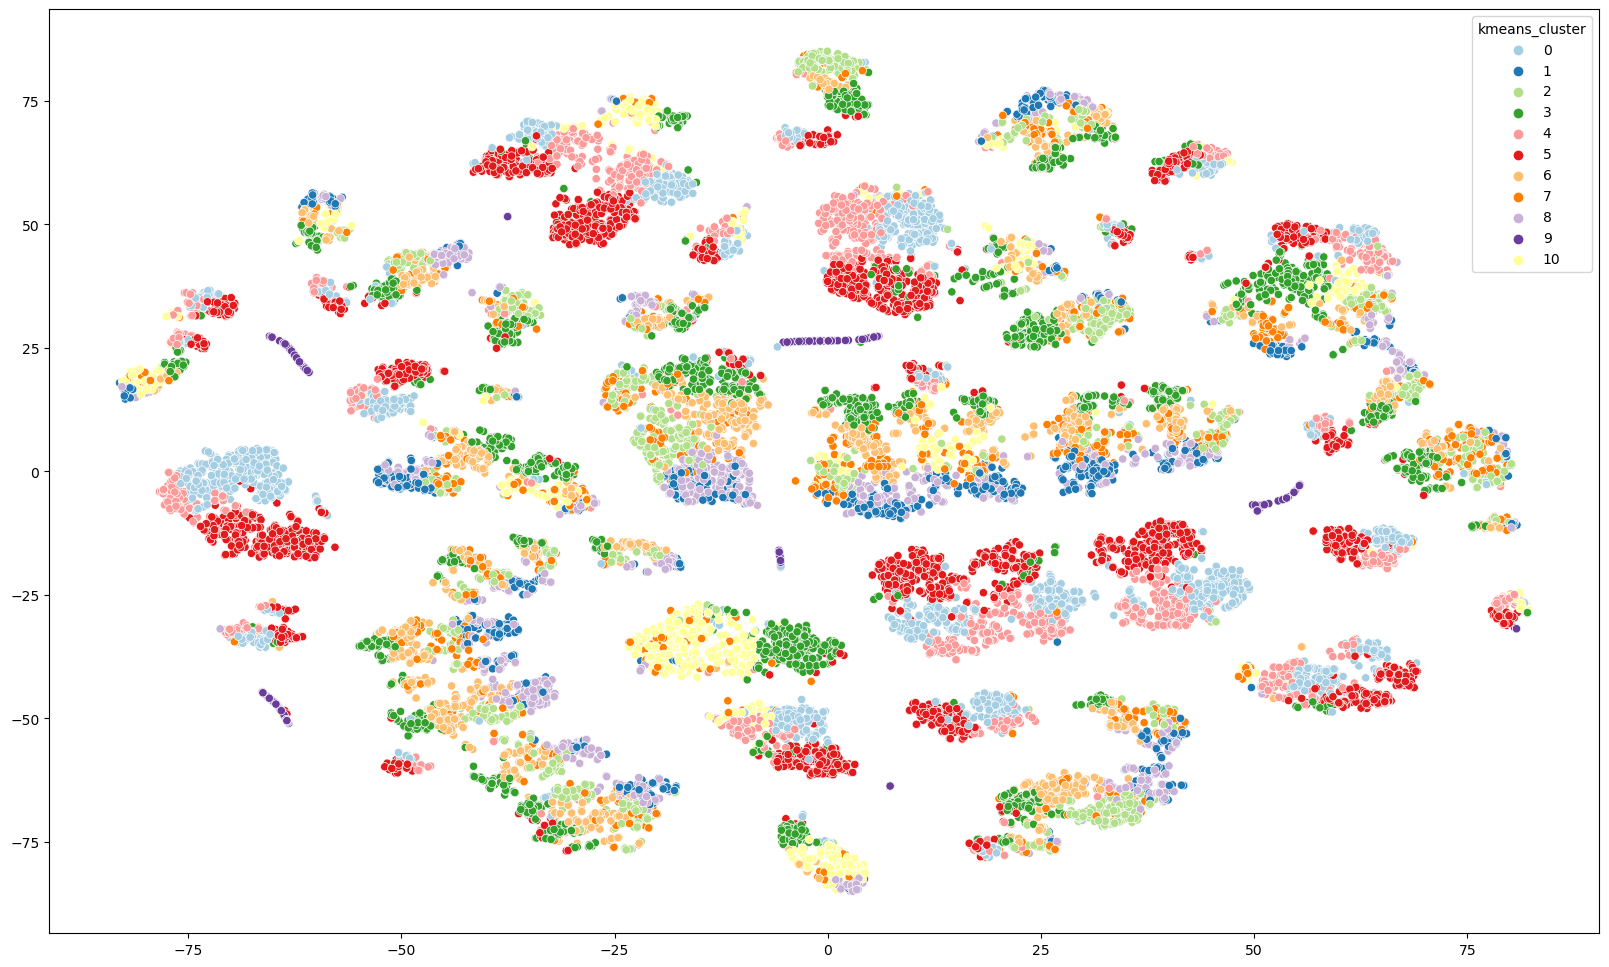

In [365]:
plt.figure(figsize=(20,12))
sns.scatterplot(x=tsne_data[:,0], y=tsne_data[:,1], hue=dota_data['kmeans_cluster'], palette="Paired")
plt.show()

## 6. Comparação entre os resultados das duas clusterizações

Index(['win', 'hero_id', 'kills', 'deaths', 'assists', 'gold', 'last_hits',
       'denies', 'gold_per_min', 'xp_per_min', 'gold_spent', 'hero_damage',
       'tower_damage', 'hero_level', 'roshans_killed', 'observers_placed',
       'dbscan_cluster', 'kmeans_cluster'],
      dtype='object')


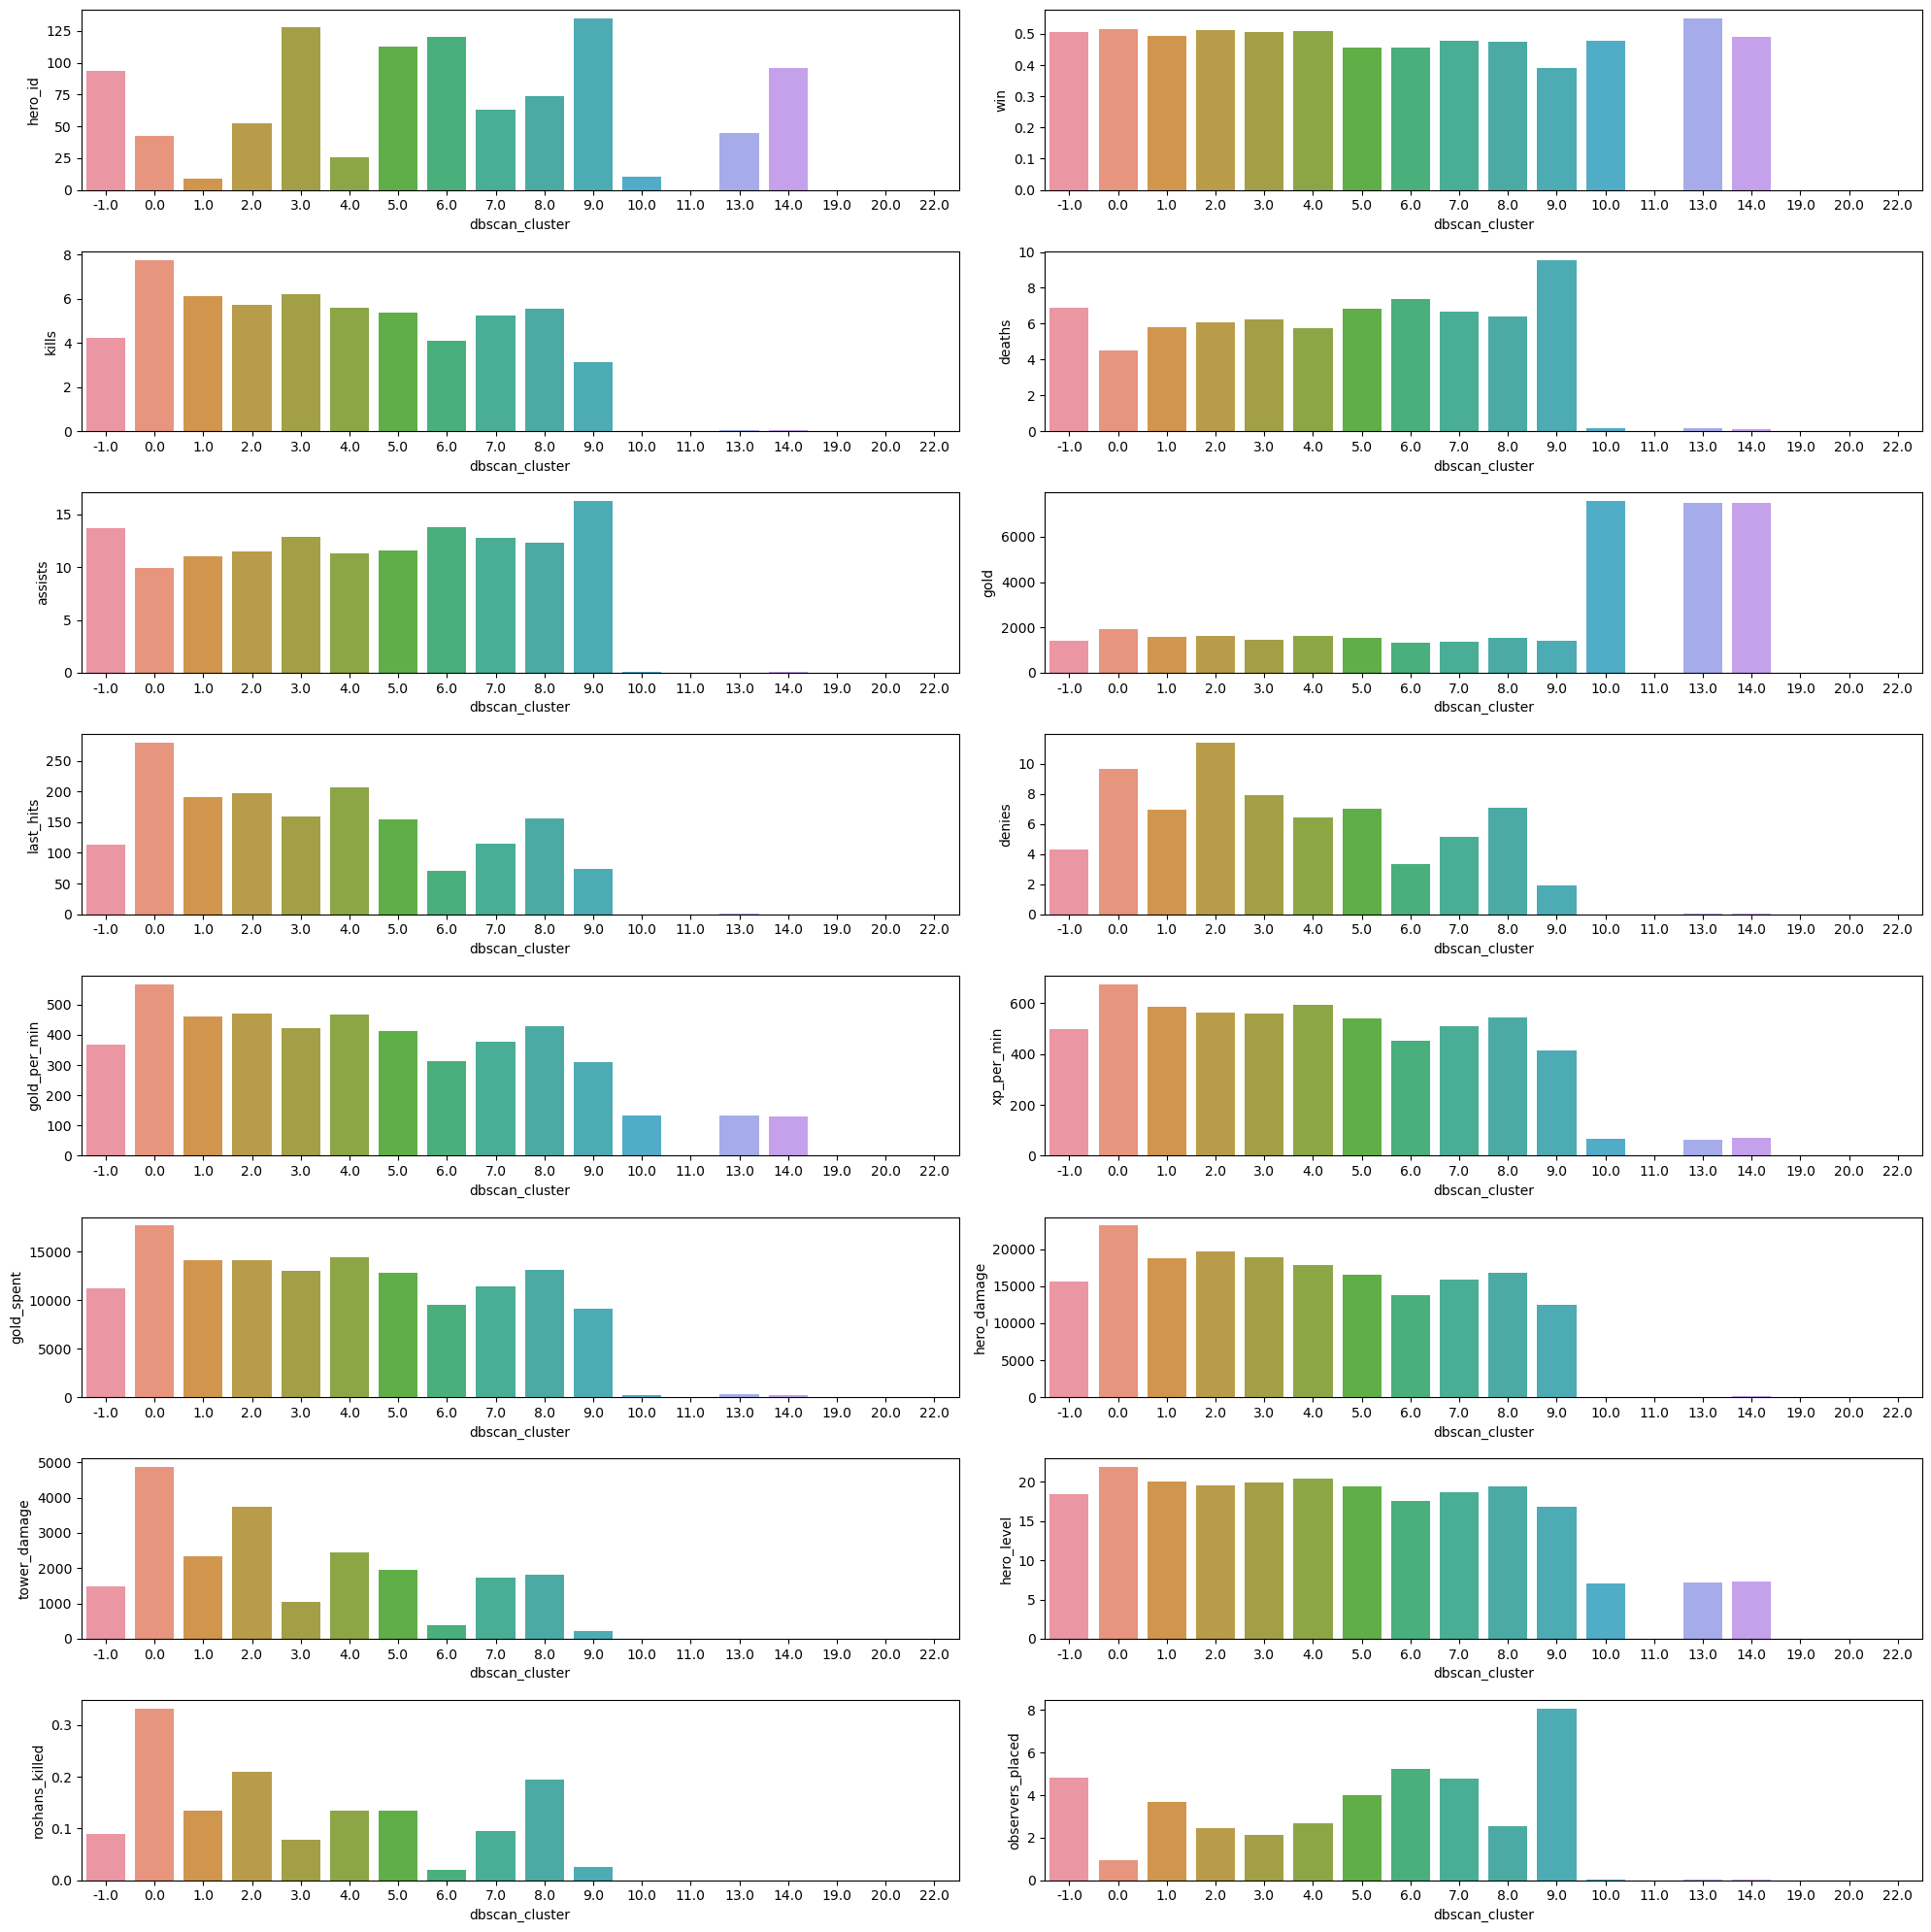

In [366]:
#dota_data.drop(["kmeans_cluster"], axis=1, inplace=True)
#Antes de progredir é necessário realizar a transformação inversa dos dados para poderem ser interpretados
bimodal_column = ['win', 'hero_id']
power_law_columns = ['tower_damage', 'gold', 'denies', 'roshans_killed', 'observers_placed']
gaussian_columns = list(set(dota_data.columns)-set(power_law_columns)-set(bimodal_column))
bimodal_dota_data = dota_data[bimodal_column]
power_law_dota_data = dota_data[power_law_columns]
gaussian_dota_data = dota_data[gaussian_columns]

#Aplicando as transformações de acordo com o tipo de distribuição
gaussian_dota_data_scaled = pd.DataFrame(StandardScaler().fit_transform(gaussian_dota_data), columns=gaussian_columns)

qt = QuantileTransformer(output_distribution='normal')
bimodal_dota_data_scaled = pd.DataFrame(StandardScaler().fit_transform(qt.fit_transform(bimodal_dota_data)), columns=bimodal_column)

pt = PowerTransformer(standardize=True)
power_law_dota_data_scaled = pd.DataFrame(pt.fit_transform(power_law_dota_data), columns=power_law_columns)

dota_data_scaled = pd.concat([gaussian_dota_data_scaled, bimodal_dota_data_scaled, power_law_dota_data_scaled], axis=1)
dota_data_scaled.head()

#Obtendo as médias dos valores das colunas para cada cluster (DBSCAN)
dbscan_cluster_hero_id = pd.DataFrame(dota_data.groupby(["dbscan_cluster"]).hero_id.mean())
dbscan_cluster_win = pd.DataFrame(dota_data.groupby(["dbscan_cluster"]).win.mean())
dbscan_cluster_kills = pd.DataFrame(dota_data.groupby(["dbscan_cluster"]).kills.mean())
dbscan_cluster_deaths =	pd.DataFrame(dota_data.groupby(["dbscan_cluster"]).deaths.mean())
dbscan_cluster_assists = pd.DataFrame(dota_data.groupby(["dbscan_cluster"]).assists.mean())
dbscan_cluster_gold = pd.DataFrame(dota_data.groupby(["dbscan_cluster"]).gold.mean())
dbscan_cluster_last_hits = pd.DataFrame(dota_data.groupby(["dbscan_cluster"]).last_hits.mean())
dbscan_cluster_denies = pd.DataFrame(dota_data.groupby(["dbscan_cluster"]).denies.mean())
dbscan_cluster_gold_per_min = pd.DataFrame(dota_data.groupby(["dbscan_cluster"]).gold_per_min.mean())
dbscan_cluster_xp_per_min = pd.DataFrame(dota_data.groupby(["dbscan_cluster"]).xp_per_min.mean())
dbscan_cluster_xp_gold_spent = pd.DataFrame(dota_data.groupby(["dbscan_cluster"]).gold_spent.mean())
dbscan_cluster_xp_hero_damage = pd.DataFrame(dota_data.groupby(["dbscan_cluster"]).hero_damage.mean())
dbscan_cluster_tower_damage = pd.DataFrame(dota_data.groupby(["dbscan_cluster"]).tower_damage.mean())
dbscan_cluster_hero_level = pd.DataFrame(dota_data.groupby(["dbscan_cluster"]).hero_level.mean())
dbscan_cluster_roshans_killed = pd.DataFrame(dota_data.groupby(["dbscan_cluster"]).roshans_killed.mean())
dbscan_cluster_observers_placed = pd.DataFrame(dota_data.groupby(["dbscan_cluster"]).observers_placed.mean())
print(dota_data.columns)

dbscan_clusters_list = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 19, 20, 22]

dota_data_analysis = pd.concat([pd.Series(dbscan_clusters_list), dbscan_cluster_hero_id, dbscan_cluster_win, dbscan_cluster_kills, dbscan_cluster_deaths,
               dbscan_cluster_assists, dbscan_cluster_gold, dbscan_cluster_last_hits, dbscan_cluster_denies, dbscan_cluster_gold_per_min, dbscan_cluster_xp_per_min,
               dbscan_cluster_xp_gold_spent, dbscan_cluster_xp_hero_damage, dbscan_cluster_tower_damage, dbscan_cluster_hero_level, dbscan_cluster_roshans_killed,
               dbscan_cluster_observers_placed], axis=1)
dota_data_analysis.columns = ['dbscan_cluster', 'hero_id', 'win',	'kills',	'deaths',	'assists',	'gold',	'last_hits',	'denies',	'gold_per_min',	'xp_per_min',	'gold_spent',
	                            'hero_damage',	'tower_damage',	'hero_level',	'roshans_killed',	'observers_placed']
dota_data_analysis

fig, axs = plt.subplots(8,2,figsize = (20,20))

sns.barplot(x=dota_data_analysis.dbscan_cluster, y=dota_data_analysis.hero_id, ax = axs[0,0])
sns.barplot(x=dota_data_analysis.dbscan_cluster, y=dota_data_analysis.win, ax = axs[0,1])
sns.barplot(x=dota_data_analysis.dbscan_cluster, y=dota_data_analysis.kills, ax = axs[1,0])
sns.barplot(x=dota_data_analysis.dbscan_cluster, y=dota_data_analysis.deaths, ax = axs[1,1])
sns.barplot(x=dota_data_analysis.dbscan_cluster, y=dota_data_analysis.assists, ax = axs[2,0])
sns.barplot(x=dota_data_analysis.dbscan_cluster, y=dota_data_analysis.gold, ax = axs[2,1])
sns.barplot(x=dota_data_analysis.dbscan_cluster, y=dota_data_analysis.last_hits, ax = axs[3,0])
sns.barplot(x=dota_data_analysis.dbscan_cluster, y=dota_data_analysis.denies, ax = axs[3,1])
sns.barplot(x=dota_data_analysis.dbscan_cluster, y=dota_data_analysis.gold_per_min, ax = axs[4,0])
sns.barplot(x=dota_data_analysis.dbscan_cluster, y=dota_data_analysis.xp_per_min, ax = axs[4,1])
sns.barplot(x=dota_data_analysis.dbscan_cluster, y=dota_data_analysis.gold_spent, ax = axs[5,0])
sns.barplot(x=dota_data_analysis.dbscan_cluster, y=dota_data_analysis.hero_damage, ax = axs[5,1])
sns.barplot(x=dota_data_analysis.dbscan_cluster, y=dota_data_analysis.tower_damage, ax = axs[6,0])
sns.barplot(x=dota_data_analysis.dbscan_cluster, y=dota_data_analysis.hero_level, ax = axs[6,1])
sns.barplot(x=dota_data_analysis.dbscan_cluster, y=dota_data_analysis.roshans_killed, ax = axs[7,0])
sns.barplot(x=dota_data_analysis.dbscan_cluster, y=dota_data_analysis.observers_placed, ax = axs[7,1])
plt.tight_layout()

Da análise do gráfico acima, tira-se diversas conclusões interessantes:

1. Grupo zero: claramente são os heróis que mais matam sejam outros heróis, personagens ou o boss Roshan (provavelmente um grupo composto por heróis classificados como carriers). Além disso, é o grupo com menor média de mortes, maior média de dano causado, com maior experiência por minuto e com maior média de level ao final das partidas. Sendo assim, é um dos grupos desejáveis para se jogar.

2. Grupo nove: este é um grupo com grande número de assistências (provavelmente um grupo composto por heróis classificados como suporte), grande número de mortes, com grande número de uso de observadores (observers_placed), mas com baixo percentual de vitórias convertidas. Este então, de acordo com a clusterização é um grupo de heróis suportes que deve ser evitado.

## 7. Resposta a algumas perguntas a respeito de séries temporais

Um determinado problema, apresenta 10 séries temporais distintas. Gostaríamos de agrupá-las em 3 grupos, de acordo com um critério de similaridade, baseado no valor máximo de correlação cruzada entre elas. Descreva em tópicos todos os passos necessários.

•	Definir o objetivo, ou seja, qual o critério de agrupamento

•	Geralmente quando se fala no agrupamento de séries temporais se fala em sincronia

•	As séries precisam ter o mesmo comprimento “n”, caso contrário pode-se ter um problema de indexação


Para o problema da questão anterior, indique qual algoritmo de clusterização você usaria. Justifique.
??

Indique um caso de uso para essa solução projetada.
•	Estação meteorológica. Série umidade relativa do ar, precipitação, temperatura.

Sugira outra estratégia para medir a similaridade entre séries temporais. Descreva em tópicos os passos necessários.
•	Correlação de Pearson. Índice de correlação. Ajuda a calcular a tendência global. É uma medida normalizada. Como desvantagem ela só captura as relações lineares e o fato de não conseguir capturar micro tendências pois há um excesso de simplificação.

•	Deve-se adaptar o índice de correlação global, para conseguir capturar as micro tendências. É interessante aplicar o Pearson em intervalos de dados. Ao invés de se fazer uma correlação única global, aplica-se a correlação para intervalos de tempo específicos.

•	Uma alternativa ao processo anterior é a correlação cruzada. Ao se maximizar a correlação cruzada, tem-se a minimização do offset entre duas séries temporais.

•	DTW. A correspondência não ocorre entre os dados em um mesmo instante de tempo. Ele implementa uma “edit distance”, que são operações de inserir e remover entradas duplicadas adjacentes com custo zero, editar uma posição a para b com o custo da distância d(b, a) e inserir ou remover zero no final de um vetor com custo zero (permite trabalhar com vetores distintos). É desta forma que o algoritmo irá encontrar a sincronia entre as séries. O algoritmo em si, trabalha minimizando um somatório de valores em uma matriz distância de forma a percorrer sua diagonal pelos menores valores possíveis, não exatamente na trajetória diagonal. Os sinais não precisam ter o mesmo comprimento.
